In [1]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from numpy.linalg import norm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
import sklearn.cluster
import math

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Import Iris

In [2]:
colors =['k','r','b','g','c','m',]
n_colors = 6

# Carregar o conjunto de dados IRIS
iris = datasets.load_iris()
X = iris.data
y_true = iris.target

#### DBSCAN

In [3]:
def EpsilonVoisinage(i,X,Dist,eps):
    N,p =np.shape(X)
    #Voisins = [v for v in range(N) if ( i != v and Dist[v,i] < eps)] 
    Voisins = [v for v in range(N) if ( Dist[v,i] < eps)] # Devemos considerar o proprio ponto no calcul
    return Voisins

###########################################################################
def etendre_cluster(X, y, Dist, Cluster, no_cluster, Voisins, Visite, eps, minpts):

    for v in Voisins:
        if not Visite[v]:
            Visite[v] = True
            if y[v] == -1:
                y[v] = no_cluster
                Cluster = Cluster + [v]

            Voisins2 = EpsilonVoisinage(v, X, Dist, eps )
            if len(Voisins2) >= minpts:
                for vv in Voisins2:
                    if vv not in Voisins:
                        Voisins.append(vv)

    return Cluster, y, Visite

###########################################################################
def estime_EPS(Dist):
    # estimation du rayon du epsilon voisinage
    N = Dist.shape[0]
    Diag = np.eye(N)*1000
    EPS = np.percentile(np.min(Dist+Diag,axis=0),95)
    
    return EPS

def estime_MINPTS(X,Dist,eps):
    # estimation de minpts dans le epsilon voisinage
    NVoisins = []
    N,pp =np.shape(X)
    for p in range(N):
        NVoisins = NVoisins+[len(EpsilonVoisinage(p,X,Dist,eps))]
        MINPTS = math.ceil(np.percentile(np.asarray(NVoisins,dtype=np.float64),5))

    return MINPTS

##########################################################################
#              MY DBSCAN
def my_DBSCAN(X, eps, minpts, Visualisation = False):
    N,pp =np.shape(X)
    no_cluster = 0
    
    # on pré-calcule toutes les distances entre points
    Dist = np.reshape(norm(X - X[0,:],axis=1),(N,1))
    for n in range(1,N):
        D = np.reshape(norm(X - X[n,:],axis=1),(N,1))
        Dist = np.concatenate((Dist,D),axis=1)

    eps = estime_EPS(Dist)
    print("eps = ", eps)
    minpts = estime_MINPTS(X,Dist,eps)
    print("minpts = ", minpts)

    Visite = [False for _ in range(N)]
    
    y = - np.ones(N)  # tableau des labels des données, initialisé bruit (-1)
    Clusters = []
    
    for p in range(N):
        if not Visite[p]:
            Visite[p] = True
            Voisins = EpsilonVoisinage(p, X, Dist, eps)
            if len(Voisins) >= minpts:
                no_cluster = no_cluster+1
                cluster = [p]
                y[p] = no_cluster
                cluster, y, Visite = etendre_cluster(X, y, Dist, cluster, no_cluster, Voisins, Visite, eps, minpts)
                Clusters.append(cluster)
            # else:
            #     continue # p est du bruit

    if Visualisation :
        print(len(Clusters),' clusters trouvés', no_cluster)
        print("Clusters =",Clusters)
        for cluster in Clusters:
            print('effectif cluster ',len(cluster))
                       
        Bruit = [n for n in range(N) if y[n] == -1]
        print('effectif  bruit',len(Bruit))

    return y

### K-means et K-means++

In [4]:
def initPlusPlus(X,K):
    N,p = np.shape(X)
    C = np.zeros((p,K))
    generator = np.random.default_rng()
    
    index = np.random.choice(N, 1,replace = False)
    liste_index = [index]
    C[:,0] = X[index,:]
    X = np.delete(X,index,0)
    print("k=0 C[k]=",C[:,0],"index=",index)
    k=1
    while k < K:
        #y = np.zeros(X.shape[0])
        NN = X.shape[0]
        dist = np.zeros(NN)
        for n in range(NN):
            D = C[:,:k] - np.repeat(X[n,:],k).reshape(p,k)
            D = np.diag(D @ D.T)
            #y[n] = np.argmin(D)
            dist[n] = np.min(D)

        # calcul des probabilités
        proba = dist/np.sum(dist)
        rand_value = generator.random((1))[0]
        intervals = np.cumsum(proba)
        index =0
        while index < NN:
            if intervals[index]> rand_value:
                break
            index += 1
        # tirage aléatoire selon proba
        C[:,k] = X[index,:]
        X = np.delete(X,index,0)
        print("k=",k,"C[k]=",C[:,k],"index=",index)
        k += 1

    return C

def my_kmeans(X,K,init, Visualisation=False,Seuil=0.001,Max_iterations = 100):
    
    N,p = np.shape(X)
    iteration = 0        
    Dist=np.zeros((K,N))

    J=np.zeros(Max_iterations+1)
    J[0] = 10000000
    # Initialisation des clusters
    # par tirage de K exemples, pour tomber dans les données     
    Index_init = np.random.choice(N, K,replace = False)
    C = np.zeros((p,K))
    
    if init == "plusplus":
        C = initPlusPlus(X, K)
    else:
        for k in range(K):
            C[:,k] = X[Index_init[k],:].T 
    
    if Visualisation: 
        fig = plt.figure(3, figsize=(8, 6))

        plt.plot(X[:,0],X[:,1],'ro')
        plt.plot(C[0,:],C[1,:],'kx')
        plt.title('Initilisation k-means++ ('+str(K)+')')
        plt.show()
    
    while iteration < Max_iterations:
        iteration +=1
        #################################################################
        # E step : estimation des données manquantes 
        #          affectation des données aux clusters les plus proches
        for k in range(K):
            Dist[k,:] = np.square(norm(X - C[:,k],axis=1))

        y = np.argmin(Dist,axis=0)
        
#        for k in range(K):
#            Nk = np.shape(X[y==k,:])[0]
#            J[iteration] += Nk / N * (np.sum(np.min(Dist[k,y==k],axis=0))/Nk)  # Crirère somme des variances intra

        J[iteration] += np.sum(np.min(Dist[y,:],axis=0))/N # Critière variance intra totale
        
        if Visualisation:
            fig = plt.figure(iteration+10, figsize=(8, 6))
            for k in range(K):
                plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
            plt.plot(C[0, :], C[1, :],'kx')
            plt.show()
        
        ################################################################
        # M Step : calcul des meilleurs centres          
        for k in range(K):
            Cluster = X[y==k,:]
            C[:,k] = np.mean(Cluster,axis=0)

        if np.abs(J[iteration]-J[iteration-1])/J[iteration-1] < Seuil:
            break
            
    if Visualisation:
        fig = plt.figure(figsize=(8, 6))
        plt.plot(J[1:iteration], 'o-')
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.show()
            
    return C, y, J[1:iteration]

### EAC

1 - Programer l'algorithme EAC

In [5]:
def evidence_accumulation_clustering(X, K, T, Seuil):
    N = X.shape[0]
    Co_Assoc = np.zeros((N, N))  # Initialize co-association matrix
    y = -np.ones(N, dtype=int)  # Initialize assignment vector with -1 for noise
    n_clusters = 0  # Number of clusters

    # Calculate the co-association matrix
    for t in range(T):
        _, yy, _ = my_kmeans(X, K, 'kmeans', Visualisation = False)  # Partition with k-means
        for i in range(N):
            for j in range(N):
                if yy[i] == yy[j]:
                    Co_Assoc[i, j] += 1 / T

    # Final partitioning based on the co-association matrix
    for i in range(N):
        for j in range(N):
            if Co_Assoc[i, j] > Seuil:
                if y[i] != -1 and y[j] != -1:
                    # Merge clusters
                    if y[i] != y[j]:
                        y[y == y[j]] = y[i]
                elif y[i] != -1:
                    y[j] = y[i]  # Assign j to i's cluster
                elif y[j] != -1:
                    y[i] = y[j]  # Assign i to j's cluster
                else:
                    # Create a new cluster
                    y[i] = y[j] = n_clusters
                    n_clusters += 1

    # Renumber clusters starting from 1, set unassigned elements to -1 (noise)
    unique_clusters = np.unique(y[y != -1])
    cluster_map = {old: new+1 for new, old in enumerate(unique_clusters)}
    y = np.array([cluster_map[val] if val in cluster_map else -1 for val in y])
    
    return y

### 2 - Evaluer EAC et comparer avec k-means++ et DBSCAN dans le Dataset Iris

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


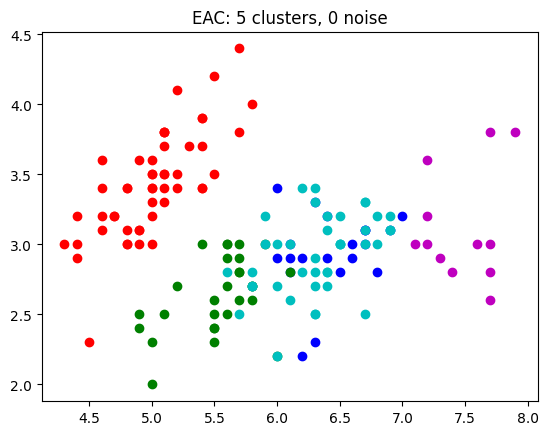

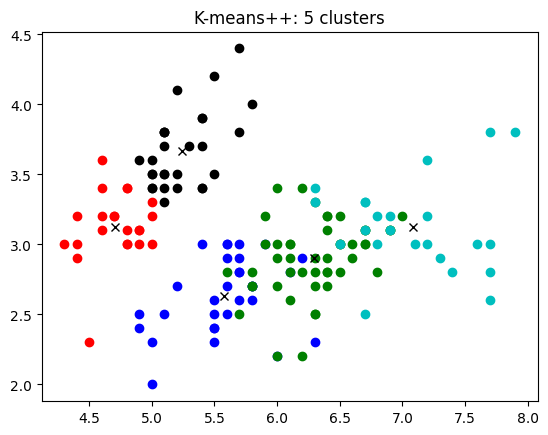

eps =  0.47565977797916165
minpts =  2


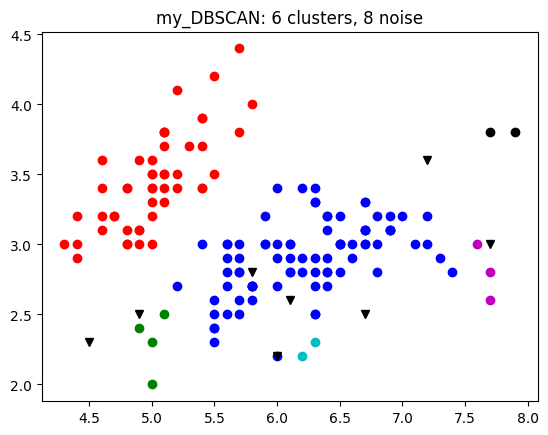

In [6]:
# Parametres default
T_default = 200
K_default = 13    
Seuil_default = 0.5  
eps = 0.7
minpts = 5


##### EAC ##########
y = evidence_accumulation_clustering(X, K_default, T_default, Seuil_default)
statistiques = np.unique(y,return_counts=True)
K = len(statistiques[0])-(1 if -1 in statistiques[0] else 0)
Bruit = [p for p in range(len(y)) if y[p]==-1]

for k in range(1,K+1):
    plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
plt.plot(X[y==-1, 0], X[y==-1, 1], 'kv')

plt.title('EAC: '+str(K)+' clusters, '+str(len(Bruit))+' noise')
plt.show()


##### K-means++ ##########
ClusterPlus, yPlus, CriterePlus = my_kmeans(X, K, 'kmeans', Visualisation = False)
for k in range(K):
    plt.plot(X[yPlus == k, 0], X[yPlus == k, 1], colors[k % len(colors)] + 'o')
plt.plot(ClusterPlus[0, :], ClusterPlus[1, :], 'kx')
plt.title(f'K-means++: {K} clusters')
plt.show()


##### DBSCAN ##########
my_y = my_DBSCAN(X,eps,minpts)
statistiques = np.unique(my_y,return_counts=True)
K = len(statistiques[0])-(1 if -1 in statistiques[0] else 0)
Bruit = [p for p in range(len(my_y)) if my_y[p]==-1]

for k in range(1,K+1):
    plt.plot(X[my_y==k, 0], X[my_y==k, 1], colors[k%n_colors]+'o')
plt.plot(X[my_y==-1, 0], X[my_y==-1, 1], 'kv')

plt.title('my_DBSCAN: '+str(K)+' clusters, '+str(len(Bruit))+' noise')
plt.show()

#### Conclusion
Comparing EAC with k-means++, we can see that the results are very similar, this suggests that EAC is also able to fix the random factor of k-means initialisation. Therefore a big issue of k-maens is fixed by EAC.

We can see that EAC gave us a better result than DBSCAN, because the second is not able to classify the extreme points in the same cluster as the dense regions, that is, we find a lot of noise in the frontiers.



### 3 - Evaluer l'influence de T

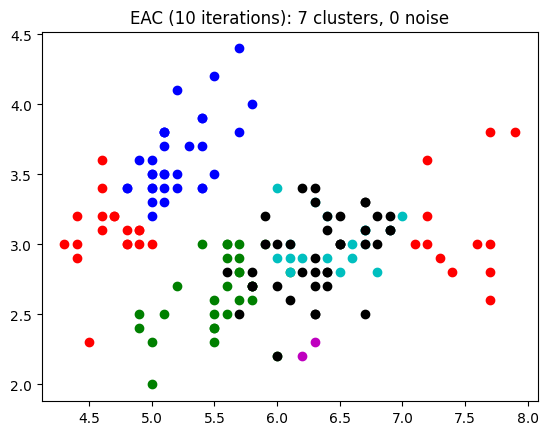

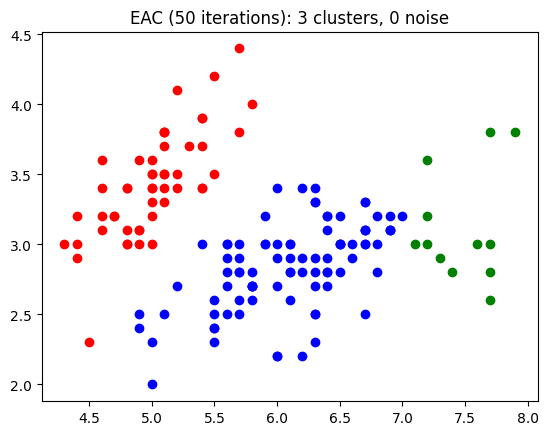

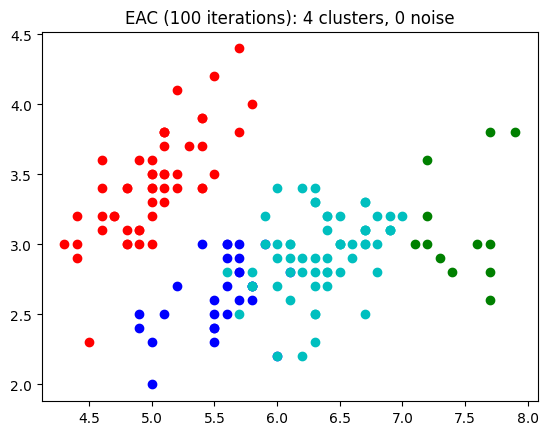

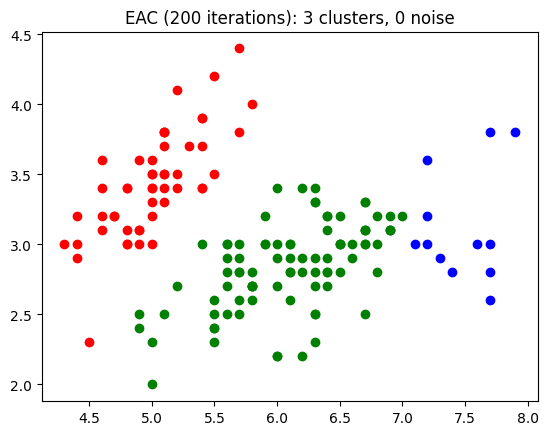

In [7]:
T_values = [10, 50, 100, 200]
K_default = 13   
Seuil_default = 0.5  


for T in T_values:
    y = evidence_accumulation_clustering(X, K_default, T, Seuil_default)
    statistiques = np.unique(y,return_counts=True)
    K = len(statistiques[0])-(1 if -1 in statistiques[0] else 0)
    Bruit = [p for p in range(len(y)) if y[p]==-1]

    for k in range(1,K+1):
        plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
    plt.plot(X[y==-1, 0], X[y==-1, 1], 'kv')

    plt.title('EAC ('+str(T)+' iterations): '+str(K)+' clusters, '+str(len(Bruit))+' noise')
    plt.show()



#### Conclusion
After several runs of the cell, it is visible that the number of clusters given by 200 iterations is much more consistent than the lower ones and with a smaller number of clusters. 

The graph with 10 iterations tend to change a lot the position of the centroids as well. Therefore, the parameter T has a great influence in controling the random factor of k-means results.

The higher number of cluster is caused by the smaller number of iterations to be added to the value of Co_Ass to make its values satisfy the condition of the seuil.

### 4 - Evaluer l'influence de K

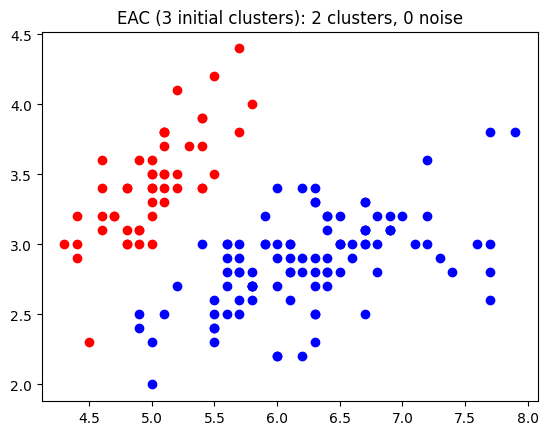

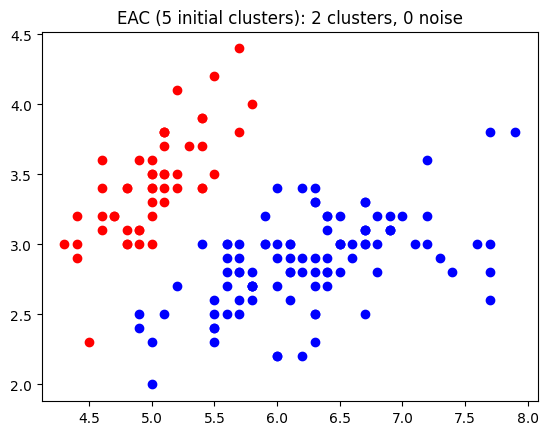

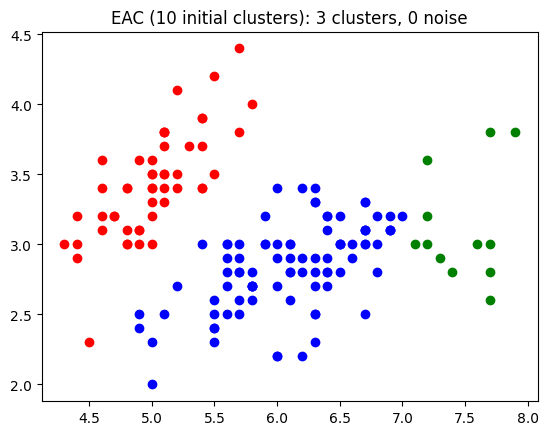

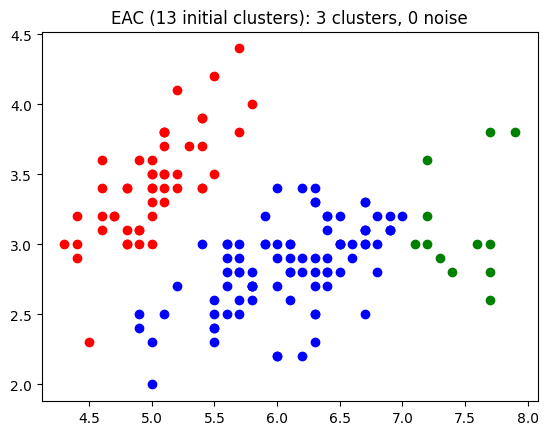

In [8]:
T_default = 200
K_values = [3, 5, 10, 13]   
Seuil_default = 0.5  


for kini in K_values:
    y = evidence_accumulation_clustering(X, kini, T_default, Seuil_default)
    statistiques = np.unique(y,return_counts=True)
    K = len(statistiques[0])-(1 if -1 in statistiques[0] else 0)
    Bruit = [p for p in range(len(y)) if y[p]==-1]

    for k in range(1,K+1):
        plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
    plt.plot(X[y==-1, 0], X[y==-1, 1], 'kv')

    plt.title('EAC ('+str(kini)+' initial clusters): '+str(K)+' clusters, '+str(len(Bruit))+' noise')
    plt.show()



### Conclusion
We can observe that the higher the initial value of K, the higher its value is in the end. Since a big initial K allows k-means to have a ideal small inertia within its clusters, the final results of K also tends to have clusters with low inertia within.

### 5 - Evaluer l'influence de Seuil

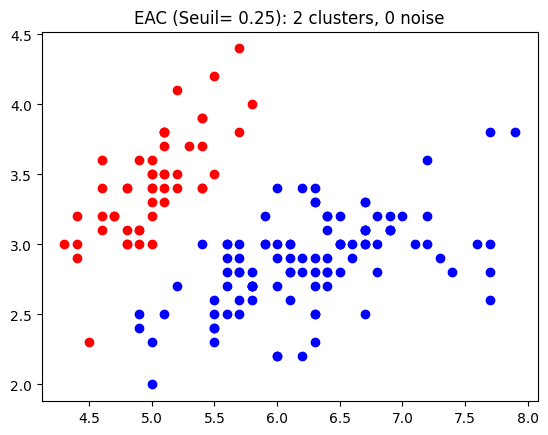

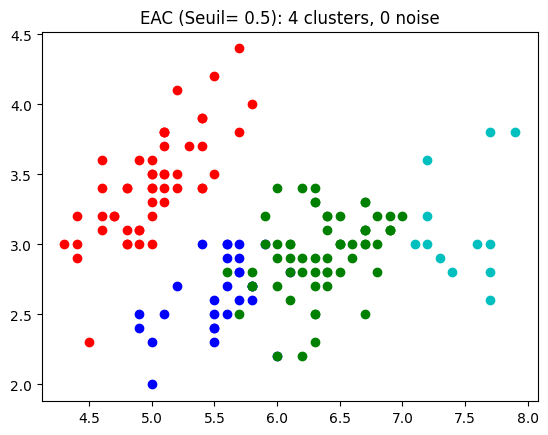

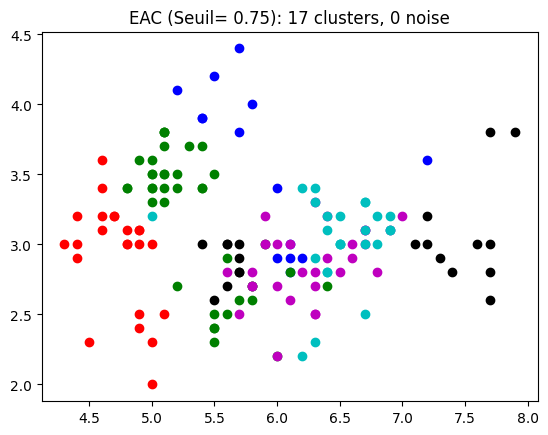

In [9]:
T_default = 200
K_default = 13
Seuil_values = [0.25, 0.5, 0.75] 


for Seuil in Seuil_values:
    y = evidence_accumulation_clustering(X, K_default, T_default, Seuil)
    statistiques = np.unique(y,return_counts=True)
    K = len(statistiques[0])-(1 if -1 in statistiques[0] else 0)
    Bruit = [p for p in range(len(y)) if y[p]==-1]

    for k in range(1,K+1):
        plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
    plt.plot(X[y==-1, 0], X[y==-1, 1], 'kv')

    plt.title('EAC (Seuil= '+str(Seuil)+'): '+str(K)+' clusters, '+str(len(Bruit))+' noise')
    plt.show()


### Conclusions
The Seuil is directly related to the number of clusters, because for high values of Seuil, the data points need to be much more similar in order to be added to the same cluster. The criteria of similarity for EAC is the frequency of classification in a same cluster by the several k-means iterated.

### 6 - Evaluer EAC et comparer avec k-means++ et DBSCAN dans le dataset Circles

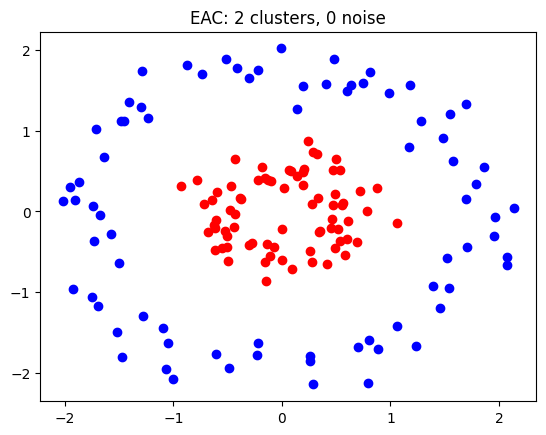

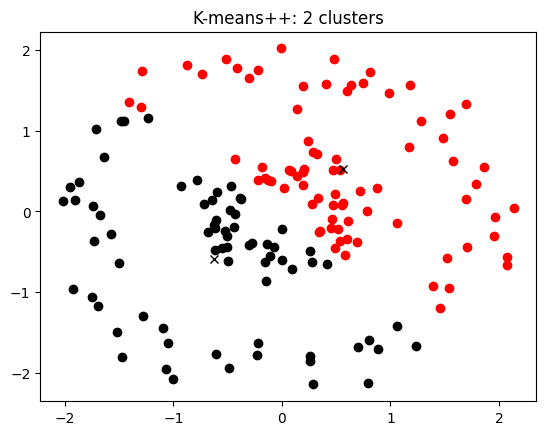

eps =  0.31663135776736034
minpts =  2


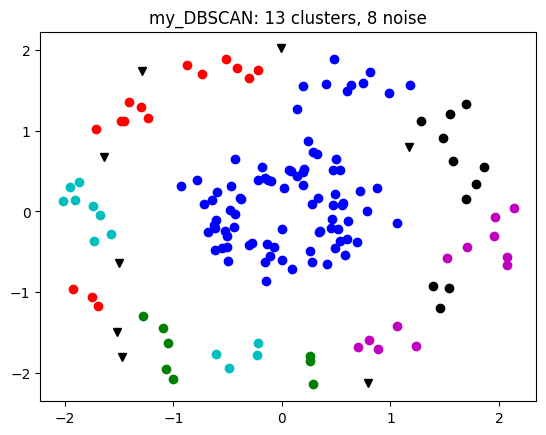

In [12]:
# Parametres default
T_default = 200
K_default = 13    
Seuil_default = 0.5  
eps = 0.7
minpts = 5

X, y = make_circles(n_samples=150, factor=0.3, noise=0.1)
X = StandardScaler().fit_transform(X)


##### EAC ##########
y = evidence_accumulation_clustering(X, K_default, T_default, Seuil_default)
statistiques = np.unique(y,return_counts=True)
K = len(statistiques[0])-(1 if -1 in statistiques[0] else 0)
Bruit = [p for p in range(len(y)) if y[p]==-1]

for k in range(1,K+1):
    plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
plt.plot(X[y==-1, 0], X[y==-1, 1], 'kv')

plt.title('EAC: '+str(K)+' clusters, '+str(len(Bruit))+' noise')
plt.show()


##### K-means++ ##########
ClusterPlus, yPlus, CriterePlus = my_kmeans(X, K, 'kmeans', Visualisation = False)
for k in range(K):
    plt.plot(X[yPlus == k, 0], X[yPlus == k, 1], colors[k % len(colors)] + 'o')
plt.plot(ClusterPlus[0, :], ClusterPlus[1, :], 'kx')
plt.title(f'K-means++: {K} clusters')
plt.show()


##### DBSCAN ##########
my_y = my_DBSCAN(X,eps,minpts)
statistiques = np.unique(my_y,return_counts=True)
K = len(statistiques[0])-(1 if -1 in statistiques[0] else 0)
Bruit = [p for p in range(len(my_y)) if my_y[p]==-1]

for k in range(1,K+1):
    plt.plot(X[my_y==k, 0], X[my_y==k, 1], colors[k%n_colors]+'o')
plt.plot(X[my_y==-1, 0], X[my_y==-1, 1], 'kv')

plt.title('my_DBSCAN: '+str(K)+' clusters, '+str(len(Bruit))+' noise')
plt.show()

### Conclusion 
It is observed that k-means++ has a problem with this dataset, because the centroids is not in the middle of data, wich leads to errors. EAC in the other hand is able to solve this problem. 
DBSCAN also faced some trouble due to the difference in density between the circle inside (very dense) and the circle outside (low density). This makes it hard to find the ideal parameters for epsilon and minpts.